## Identifying mountain names in text using pre-trained BERT model

In [ ]:
!pip install torch transformers pandas scikit-learn
!pip install seqeval

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm, trange


#### The dataset was generated using GPT-chat

In [ ]:
data = pd.read_csv("mountains dataset.csv", encoding="latin1").fillna(method="ffill")
data_add = pd.read_csv("not_mountains dataset.csv", encoding="latin1").fillna(method="ffill")

data_add.tail(10)

,Word_id,Sentence_id,Word,Label
206,207,31,Cappadocia,O
207,208,32,Marvel,O
208,209,32,at,O
209,210,32,the,O
210,211,32,crystal,O
211,212,32,clear,O
212,213,32,waters,O
213,214,32,of,O
214,215,32,the,O
215,216,32,Maldives,O


In [ ]:
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, l) for w, l in zip(s["Word"].values.tolist(),
                                                           s["Label"].values.tolist())]
        self.grouped = self.data.groupby("Sentence_id").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None


In [ ]:
getter_add = SentenceGetter(data_add)
getter = SentenceGetter(data)
sentences = [[word[0] for word in sentence] for sentence in getter.sentences]
sentences[79]

sentences_add = [[word[0] for word in sentence] for sentence in getter_add.sentences]


In [ ]:
labels = [[s[1] for s in sentence] for sentence in getter.sentences]
labels_add = [[s[1] for s in sentence] for sentence in getter_add.sentences]
print(len(labels))
print(len(labels_add))

87
27


In [ ]:
sentences.extend(sentences_add)
labels.extend(labels_add)
print(len(sentences)," ",len(labels))

141   114


In [ ]:
tag_values = list(set(data["Label"].values))
tag_values.append("PAD")
tag2idx = {t : i for i, t in enumerate(tag_values)}

In [ ]:
print(tag_values)
print(tag2idx)

['O', 'I', 'B', 'PAD']
{'O': 0, 'I': 1, 'B': 2, 'PAD': 3}


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split

torch.__version__

'2.1.0+cu118'

In [ ]:
MAX_LEN = 75
bs = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences, labels)
]
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
tokenized_labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

In [ ]:
print(tokenized_texts[2])
print(tokenized_labels[2])

['Hi', '##king', 'enthusiasts', 'often', 'choose', 'the', 'Him', '##alaya', '##s', 'for', 'challenging', 't', '##rek', '##s']
['O', 'O', 'O', 'O', 'O', 'O', 'B', 'B', 'B', 'O', 'O', 'O', 'O', 'O']


In [ ]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="int64", value=0.0,
                          truncating="post", padding="post")
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in tokenized_labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="int64", truncating="post")
print(input_ids[0])
print(tags[0])
print(tokenized_texts[0])
#create the mask to ignore the padded elements in the sequences.
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]
print(attention_masks)

[ 1130  1103  8185 24555  1116  1106  1103  3701 13413  1132  4022  1106
  2567 10458 23574     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0]
[0 0 2 2 2 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3]
['In', 'the', 'Car', '##pathian', '##s', 'to', 'the', 'winter', 'holidays', 'are', 'invited', 'to', 'numerous', 'ski', 'resorts']
[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

In [ ]:
type(input_ids[0][0])

numpy.int64

In [ ]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2023, test_size=0.2)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2023, test_size=0.2)

#convert the dataset to torch tensors
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [ ]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)


In [ ]:
import transformers
from transformers import BertForTokenClassification
from torch.optim import Adam

transformers.__version__

'4.35.2'

In [ ]:
model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.cuda()

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

In [ ]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = Adam(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)


In [ ]:
#add a scheduler to linearly reduce the learning rate throughout the epochs
from transformers import get_linear_schedule_with_warmup

epochs = 25
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [ ]:
from seqeval.metrics import f1_score, accuracy_score

Finetune the model

In [ ]:
## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    print("Validation F1-Score: {}".format(f1_score([pred_tags], [valid_tags])))
    print()


Epoch:   0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PAD seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
Epoch:   4%|▍         | 1/25 [00:01<00:30,  1.26s/it]

Average train loss: 1.0388170878092449
Validation loss: 0.605815052986145
Validation Accuracy: 0.0
Validation F1-Score: 0.0



Epoch:   8%|▊         | 2/25 [00:02<00:28,  1.23s/it]

Average train loss: 0.586364765961965
Validation loss: 0.49919429421424866
Validation Accuracy: 0.0
Validation F1-Score: 0.0



Epoch:  12%|█▏        | 3/25 [00:03<00:26,  1.23s/it]

Average train loss: 0.49309192101160687
Validation loss: 0.415215402841568
Validation Accuracy: 0.006920415224913495
Validation F1-Score: 0.0



Epoch:  16%|█▌        | 4/25 [00:04<00:25,  1.23s/it]

Average train loss: 0.3979963759581248
Validation loss: 0.29208722710609436
Validation Accuracy: 0.20069204152249134
Validation F1-Score: 0.0



Epoch:  20%|██        | 5/25 [00:06<00:24,  1.23s/it]

Average train loss: 0.2900637884934743
Validation loss: 0.1905769556760788
Validation Accuracy: 0.7577854671280276
Validation F1-Score: 0.0



Epoch:  24%|██▍       | 6/25 [00:07<00:23,  1.24s/it]

Average train loss: 0.20468376576900482
Validation loss: 0.16701805591583252
Validation Accuracy: 0.7577854671280276
Validation F1-Score: 0.0



Epoch:  28%|██▊       | 7/25 [00:08<00:22,  1.23s/it]

Average train loss: 0.1633558968702952
Validation loss: 0.14213506877422333
Validation Accuracy: 0.7612456747404844
Validation F1-Score: 0.0



Epoch:  32%|███▏      | 8/25 [00:09<00:21,  1.24s/it]

Average train loss: 0.14131681621074677
Validation loss: 0.10607568174600601
Validation Accuracy: 0.7612456747404844
Validation F1-Score: 0.0



Epoch:  36%|███▌      | 9/25 [00:11<00:19,  1.24s/it]

Average train loss: 0.11786740769942601
Validation loss: 0.08770491927862167
Validation Accuracy: 0.8304498269896193
Validation F1-Score: 0.0



Epoch:  40%|████      | 10/25 [00:12<00:18,  1.24s/it]

Average train loss: 0.10052117208639781
Validation loss: 0.0777447298169136
Validation Accuracy: 0.8304498269896193
Validation F1-Score: 0.0



Epoch:  44%|████▍     | 11/25 [00:13<00:17,  1.24s/it]

Average train loss: 0.08611428737640381
Validation loss: 0.06936930119991302
Validation Accuracy: 0.8373702422145328
Validation F1-Score: 0.0



Epoch:  48%|████▊     | 12/25 [00:14<00:16,  1.24s/it]

Average train loss: 0.07629167536894481
Validation loss: 0.06184867024421692
Validation Accuracy: 0.8788927335640139
Validation F1-Score: 0.44000000000000006



Epoch:  52%|█████▏    | 13/25 [00:16<00:14,  1.24s/it]

Average train loss: 0.06817758580048879
Validation loss: 0.05402090772986412
Validation Accuracy: 0.8788927335640139
Validation F1-Score: 0.4150943396226416



Epoch:  56%|█████▌    | 14/25 [00:17<00:13,  1.24s/it]

Average train loss: 0.06081952775518099
Validation loss: 0.04763048514723778
Validation Accuracy: 0.8996539792387543
Validation F1-Score: 0.39344262295081966



Epoch:  60%|██████    | 15/25 [00:18<00:12,  1.25s/it]

Average train loss: 0.052264137814442314
Validation loss: 0.0430881604552269
Validation Accuracy: 0.903114186851211
Validation F1-Score: 0.47058823529411764



Epoch:  64%|██████▍   | 16/25 [00:19<00:11,  1.25s/it]

Average train loss: 0.04775771498680115
Validation loss: 0.03959818184375763
Validation Accuracy: 0.9100346020761245
Validation F1-Score: 0.5074626865671642



Epoch:  68%|██████▊   | 17/25 [00:21<00:10,  1.25s/it]

Average train loss: 0.04171344886223475
Validation loss: 0.03689233213663101
Validation Accuracy: 0.9134948096885813
Validation F1-Score: 0.5373134328358209



Epoch:  72%|███████▏  | 18/25 [00:22<00:08,  1.26s/it]

Average train loss: 0.03816417853037516
Validation loss: 0.035200029611587524
Validation Accuracy: 0.916955017301038
Validation F1-Score: 0.5671641791044776



Epoch:  76%|███████▌  | 19/25 [00:23<00:07,  1.26s/it]

Average train loss: 0.03574757029612859
Validation loss: 0.03419845178723335
Validation Accuracy: 0.9238754325259516
Validation F1-Score: 0.6268656716417911



Epoch:  80%|████████  | 20/25 [00:24<00:06,  1.26s/it]

Average train loss: 0.03296196026106676
Validation loss: 0.03354828059673309
Validation Accuracy: 0.9273356401384083
Validation F1-Score: 0.6363636363636364



Epoch:  84%|████████▍ | 21/25 [00:26<00:05,  1.26s/it]

Average train loss: 0.03084859624505043
Validation loss: 0.033280324190855026
Validation Accuracy: 0.9273356401384083
Validation F1-Score: 0.6363636363636364



Epoch:  88%|████████▊ | 22/25 [00:27<00:03,  1.27s/it]

Average train loss: 0.031184339274962742
Validation loss: 0.03317724168300629
Validation Accuracy: 0.9273356401384083
Validation F1-Score: 0.6363636363636364



Epoch:  92%|█████████▏| 23/25 [00:28<00:02,  1.27s/it]

Average train loss: 0.0305612962692976
Validation loss: 0.033089544624090195
Validation Accuracy: 0.9273356401384083
Validation F1-Score: 0.6363636363636364



Epoch:  96%|█████████▌| 24/25 [00:30<00:01,  1.28s/it]

Average train loss: 0.027948375170429546
Validation loss: 0.03305990993976593
Validation Accuracy: 0.9273356401384083
Validation F1-Score: 0.6363636363636364



Epoch: 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]

Average train loss: 0.027798142284154892
Validation loss: 0.03303615376353264
Validation Accuracy: 0.9273356401384083
Validation F1-Score: 0.6363636363636364



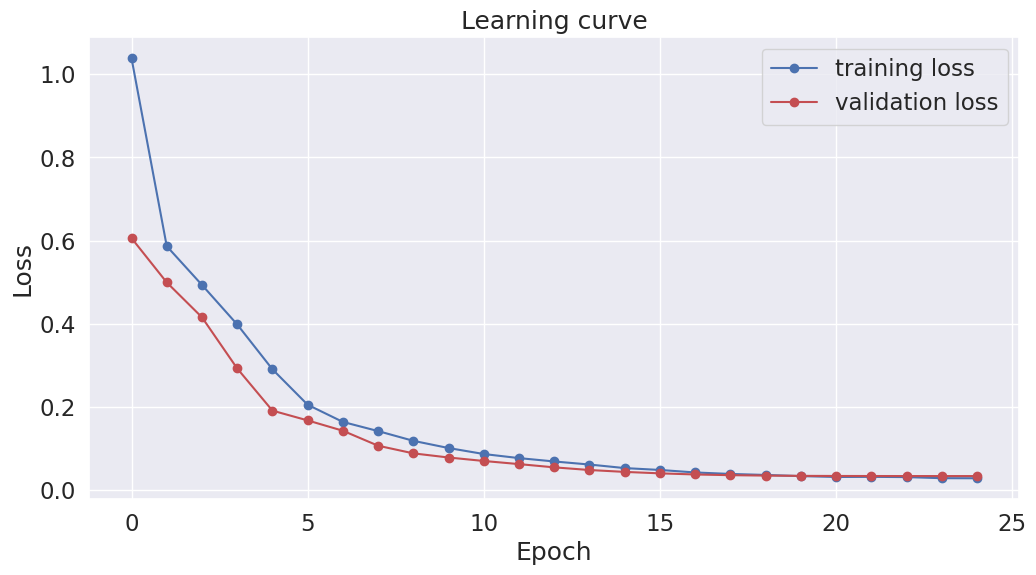

In [ ]:
#visualization
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [ ]:
test_sentence = "Flooding on the Amur River receding very slowly"

tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()

with torch.no_grad():
    output = model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)


# join bpe split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)

for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))


PAD	[CLS]
O	Flooding
PAD	on
O	the
B	Amur
O	River
O	receding
O	very
O	slowly
B	[SEP]


In [ ]:
model.save_pretrained("model")